## Plot Graphs using John-Hopkins Data about Covid-19 Cases

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import matplotlib.pylab as pylab
from statsmodels.tsa.seasonal import seasonal_decompose

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (17, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'14',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
            #lines.linewidth : 3
            #lines.markersize : 10
pylab.rcParams.update(params)


def prepare(data, countries=None, MA=4):
    """
    create a dataframe for selected countries starting for each country from the first day with at least 100 confirmed cases
    
    MA for:
    - doubling times: +4
    - daily_new_cases: +4
    - daily_rate: +4
    """
    df = data.copy()
    
    #PARAMETERS
    startcases = 100
    maxdays = 2000
    #number of intensive care beds; https://www.sciencemediacenter.de/alle-angebote/fact-sheet/details/news/auslastung-der-intensivstationen-zahlen-aus-deutschland-und-europa/
    d_no_beds = 28031
    #share of patients that need intensive care out of all confirmed cases
    intensive = 0.06
    #average days in intensive care of severe cases 
    days_int = 21
    
    df["confirmed_lag"] = df.groupby(['Country'])["Confirmed"].shift(1)
    df["deaths_lag"] = df.groupby(['Country'])["Deaths"].shift(1)
    df["daily_new_cases"] = df["Confirmed"] - df["confirmed_lag"]
    df["daily_deaths"] = df["Deaths"] - df["deaths_lag"]
    df.loc[(df["daily_new_cases"]<=1)|(pd.isnull(df["daily_new_cases"])), "daily_new_cases"] = 1
    df["daily_new_cases_log"] = np.log(df["daily_new_cases"])
    df.loc[(df["daily_new_cases_log"]<=0)|(pd.isnull(df["daily_new_cases_log"])), "daily_new_cases_log"] = np.log(1+1e-8)
    #df.loc[, 'daily_new_cases'] = 1
    #df["daily_new_cases_sd"] = ""
    
    #df = df.set_index('Date')
    for country in df["Country"].unique():
        df_country_log = df.loc[df["Country"]==country, "daily_new_cases_log"]
        df_country = df.loc[df["Country"]==country, "daily_new_cases"]
    #try:    
        dec_mul = seasonal_decompose(df_country, model='multiplicative', extrapolate_trend='freq', freq=7)
        df.loc[df["Country"]==country, "daily_new_cases_sd_mul"] = (dec_mul.trend * dec_mul.resid)
        df.loc[df["Country"]==country, "daily_new_cases_sd_trend"] = dec_mul.trend
        dec_add = seasonal_decompose(df_country_log, model='additive', extrapolate_trend='freq', freq=7)
        df.loc[df["Country"]==country, "daily_new_cases_sd_add"] = np.e**(dec_add.trend + dec_add.resid)
        
    #except ValueError:
     #   print("country - ValueError")
      #  df.loc[df["Country"]==country, "daily_new_cases_sd"] = np.nan
            
    #restrict dataframe to selected countries
    if countries == None:
        df = df[df["Confirmed"]>=startcases]
        countries = df["Country"].unique()
    else:
        df = df[(df["Country"].isin(countries))&(df["Confirmed"]>=startcases)]

    #create days since start
    df['days_since_100'] = df.groupby(['Country']).cumcount()
    #restrict to maximum days
    df = df[df['days_since_100'] < maxdays]

    #calculate confirmed cases per capita
    df["confirmed_pc"] = df["Confirmed"]/df["pop_2018"]

    #create log, lagged_log and diff/growth rate
    df = df.sort_values(["Country", 'days_since_100'])
    df["confirmed_log"] = np.log(df["Confirmed"])
    df["confirmed_log"] = np.log(df["Confirmed"])
     
    df["confirmed_lag"] = df.groupby(['Country'])["Confirmed"].shift(1) 
    df["confirmed_log_lag"] = df.groupby(['Country'])["confirmed_log"].shift(1) 
    df["daily_rate"] = df["confirmed_log"] - df["confirmed_log_lag"] 
     #
    df["doubling_time"] = np.log(2)/np.log(1+df["daily_rate"]) #

    #calculate current number of persons in intensive care
    term = 0
    for i in range(days_int):
        term += df["daily_new_cases"].shift(i)
    df["curr_int"] = term * intensive #
    
    #calculate moving average of: doubling_time, daily_rate, daily_new_cases
    term, term2, term3 = 0, 0, 0
    for i in range(MA):
        term += df["daily_rate"].shift(i)
        term2 += df["daily_new_cases"].shift(i)
        term3 += df["doubling_time"].shift(i)
    df["daily_rate_ma"] = term / MA #
    df["daily_new_cases_ma"] = term2 / MA #
    df["doubling_time_ma"] = term3 / MA #
    #df[np.isnan(df["daily_rate_ma"])].daily_rate_ma = np.nan
    df.loc[np.isnan(df.daily_rate_ma), 'daily_rate_ma'] = np.nan
    return df

def plot_data(df, columns=None, MA=4):
    """
    
    """

    global OUTPUT_PATH
    
    #GET LATEST DATE OF UPDATE
    version = np.sort(df.index.unique(), axis=0)[-1].astype('datetime64[D]')
    print(str(version))
      
    translate = {"Confirmed": "Cumulated Number of Confirmed Cases", "Confirmed_dec": "Cumulated Number of Confirmed Cases (seasonal Adjusted)","Recovered": "Cumulated Number of Recovered Cases", "Deaths": "Cumulated Number of Deaths", 
                 "pop_2018": "Country Population in 2018", "days_since_100":"Days since 100 Confirmed Cases", "confirmed_pc": "Cumulated Number of Confirmed Cases per Capita", 
                 "daily_rate": "Daily Growth Rate", "daily_new_cases": "Daily new Cases", "doubling_time": "Doubling Time in Days", 
                 "curr_int": "Number of Persons in Intensive Care", "daily_rate_ma": "Daily Growth-Rate (Moving-Average +{})".format(MA), 
                 "daily_new_cases_ma": "Daily new Cases (Moving Average +{})".format(MA), "doubling_time_ma": "Doubling Times (Moving Average +{})".format(MA)}
    
    if columns == None:
        
        #CREATE PLOTS FOR:
        columns = ["confirmed_pc", "daily_rate", "daily_rate_ma", "doubling_time", "doubling_time_ma"]
        
        for i, column in enumerate(columns, 3):
            fig, ax = plt.subplots()
            df.pivot_table(index='days_since_100',columns='Country',values=column).plot(ax=ax)
            ax.set_xlabel(translate["days_since_100"])
            ax.set_title(translate[column]+" - Version: "+str(version), pad=20)
            fig.savefig(OUTPUT_PATH+'0{}_{}.jpg'.format(i, column))
            
            if column not in ["daily_rate", "daily_rate_ma"]:
                fig, ax = plt.subplots()
                df.pivot_table(index='days_since_100',columns='Country',values=column).plot(ax=ax, logy=True)
                ax.set_xlabel(translate["days_since_100"])
                ax.set_title(translate[column]+" (log-Scale) - Version: "+str(version), pad=20)
                ax.legend(loc='upper left')
                fig.savefig(OUTPUT_PATH+'0{}_{}_log.jpg'.format(i, column))
        
        fig_1, ax_1 = plt.subplots()
        df.pivot_table(index='days_since_100',columns='Country',values='daily_new_cases').plot(figsize=(15,10), kind="bar", title=translate["daily_new_cases"]+" - Version: "+str(version), ax=ax_1)
        fig_1.savefig(OUTPUT_PATH+'01_daily_new.jpg')
        fig_1, ax_1 = plt.subplots()
        df.pivot_table(index='days_since_100',columns='Country',values='daily_new_cases_ma').plot(figsize=(15,10), kind="bar", title=translate["daily_new_cases_ma"]+" - Version: "+str(version), ax=ax_1)
        fig_1.savefig(OUTPUT_PATH+'01_daily_new_cases_ma.jpg')
        
        #initialize figure for current intensive care plot
        fig_3, ax_3 = plt.subplots(figsize=(15,6))

        for country in df.Country.unique():
            dfc = df[df["Country"]==country]
            #CUMULATED CONFIRMED, RECOVERED and DEATHS
            fig_4, ax_4 = plt.subplots(figsize=(17,10))
            #fig_2.suptitle('test title', fontsize=15)
            X = dfc.days_since_100.values
            Y1 = df[df["Country"]==country].Confirmed.values
            Y3 = df[df["Country"]==country].Deaths.values
            Y2 = df[df["Country"]==country].Recovered.values + Y3         
            ax_4.plot(Y1, 'y')
            ax_4.plot(Y2, 'g')
            ax_4.plot(Y3, 'k')
            ax_4.fill_between(X, Y1, Y2,
                where=Y1 >= Y2,
                facecolor='yellow', alpha=0.2, interpolate=True, label="Active Cases")
            ax_4.fill_between(X, Y2, Y3,
                where=Y2 >= Y3,
                facecolor='green', alpha=0.2, interpolate=True, label="Recovered Cases")
            ax_4.fill_between(X, Y3, np.zeros(len(Y2)),
                where=Y3 >= 0,
                facecolor='black', alpha=0.2, interpolate=True, label="Deaths")
            ax_4.set_title("Numbers for "+country+" - Version: "+str(version), pad=20) #fontdict={'fontsize': 18, 'fontweight': 'medium'}
            ax_4.set_xlabel(translate["days_since_100"])
            ax_4.legend()
            fig_4.show()
            fig_4.savefig(OUTPUT_PATH+'02_active_cases_{}.jpg'.format(country))
            
            #CURRENT NUMBER OF PERSONS IN INTENSIVE CARE
            ax_3.plot(dfc.Date, dfc["curr_int"].values, label=country)
        
        ax_3.set_title(translate["curr_int"]+" - Version: "+str(version), pad=20)
        ax_3.set_xlabel("Date")
        fig_3.show()
        fig_3.savefig(OUTPUT_PATH+'03_intensive_care.jpg')
        
    else:    
        for column in columns:
            title = translate[column]
            fig, axs = plt.subplots(figsize=(15,10))#2,2, 
            axs.set_title("hallo")
            d1.pivot_table(index='days_since_100',columns='Country',values=column).plot(kind="plot", title=title, ax=axs)    

    
if __name__ == "__main__":

    #GLOBAL VARIABLE
    OUTPUT_PATH = "C:/Users/Machete/Documents/Python Projects/COVID-19_DATA/covid_graphs/"
    
    #pull latest version from github
    d = "C:/Users/Machete/Documents/Python Projects/COVID-19_DATA/"
    print(d)
    os.chdir("C:/Users/Machete/Documents/Python Projects/COVID-19_DATA/covid-19")
    os.system("git pull")
    os.chdir(d)

    #input file path
    fname = 'covid-19/data/countries-aggregated.csv'
    data = pd.read_csv(fname, delimiter=',', parse_dates=True)
    data['Date'] = pd.to_datetime(data['Date'], infer_datetime_format=True, format = '%d/%m/%Y')
    #data = data.set_index('Date')

    #import country population data 
    cname = 'Population_Data/API_SP.POP.TOTL_DS2_en_csv_v2_887275.csv'
    countries_df = pd.read_csv(cname, delimiter=',', parse_dates=True)
    countries_df = countries_df.rename(columns={"Country Name": "Country"})[["Country", "2018"]]
    countries_df['Country'] = countries_df['Country'].str.replace("United States", "US")

    #get desired input countries
    countries = sys.argv[1:]

    #merge covid and population data
    data = data.merge(countries_df, how="outer", left_on='Country', right_on='Country' ).rename(columns={"2018": "pop_2018"})
    data = data.drop(list(data[pd.isnull(data["Date"])].index))    
    #select countries and execute program
    #countries = ["Germany", "United Kingdom", "Spain", "Italy"]
    
    df1 = prepare(data)

C:/Users/Machete/Documents/Python Projects/COVID-19_DATA/


C:\Users\Machete\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
C:\Users\Machete\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead


Newest Datapoint:  2021-06-24 00:00:00  - new cases (uncorrected):  475.0


C:\Users\Machete\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  del sys.path[0]
C:\Users\Machete\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


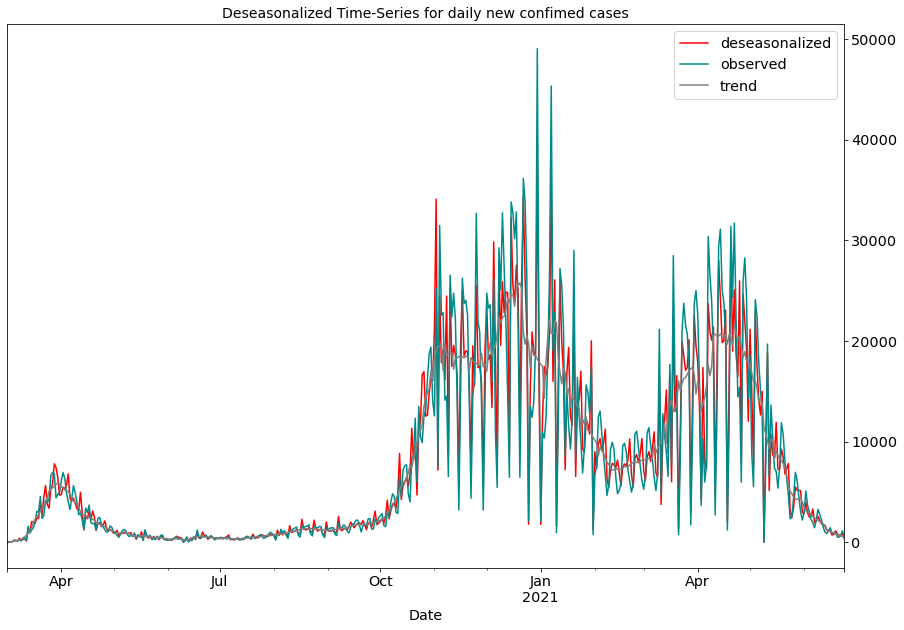

In [26]:
#choose country and get daily-new-cases time-series
try:
    df1.set_index('Date', inplace=True)
except KeyError:
    pass

country = "Germany"
daily_new = df1.loc[df1["Country"]==country, "daily_new_cases"]

print("Newest Datapoint: ", daily_new.index[-1], " - new cases (uncorrected): ", daily_new[-1])
max_ind_time = daily_new.index.max()
#do first decomposition
dec_mul_1 = seasonal_decompose(daily_new, model='multiplicative', extrapolate_trend='freq', freq=7)
max_ind = dec_mul_1.trend.loc[dec_mul_1.trend.values==dec_mul_1.trend.values.max()].index[0]
fig1, ax1 = plt.subplots(figsize=(15,10))
(dec_mul_1.observed/dec_mul_1.seasonal).plot(ax=ax1, color="red", label="deseasonalized")
dec_mul_1.observed.plot(ax=ax1, color="darkcyan", label="observed")
dec_mul_1.trend.plot(ax=ax1, color="grey", label="trend")

ax1.legend()
ax1.set_title("Deseasonalized Time-Series for daily new confimed cases")
ax1.set_xlim([pd.datetime(2020, 3, 1),max_ind_time]) #max_ind
#ax1.set_ylim([100,20000])
ax1.yaxis.tick_right()


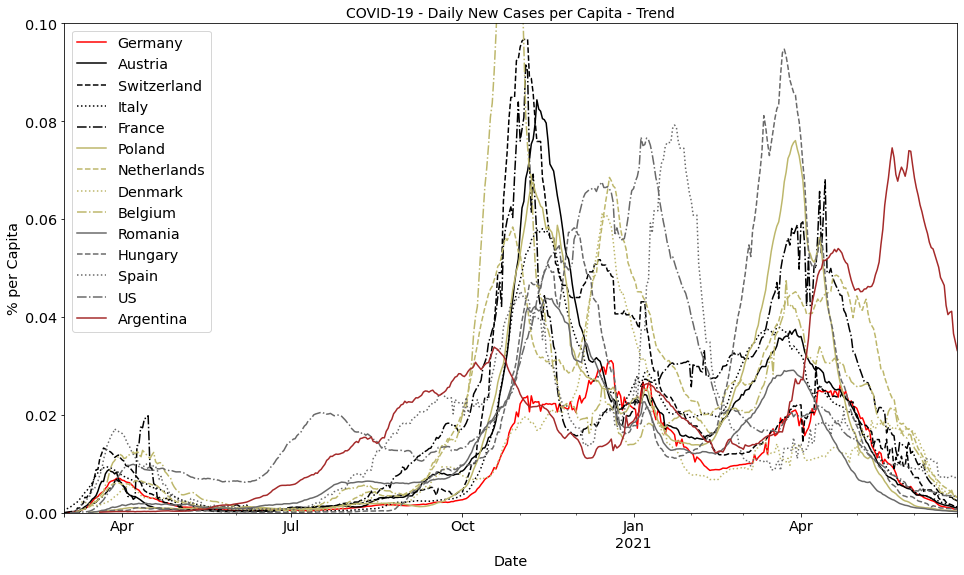

In [6]:
figp, axp = plt.subplots(figsize=(16, 9))

countries = ["Austria", "Switzerland", "Italy", "France", "Poland", "Netherlands", "Denmark", "Belgium", "Romania", "Hungary", "Spain", "US", "Argentina"]
lines = ['-', '--', ':', '-.']
color = ['black', 'darkkhaki', 'dimgray', 'brown']
daily_new_p = df1.loc[df1["Country"]=="Germany", "daily_new_cases"]/df1.loc[df1["Country"]=="Germany", "pop_2018"]*100
dec_mul_p = seasonal_decompose(daily_new_p, model='multiplicative', extrapolate_trend='freq', period=7)
dec_mul_p.trend.plot(ax=axp, label="Germany", color="red", ls="-")

for i, country in enumerate(countries):
    j = i%len(lines)
    k = int(i / len(lines))
    daily_new_p = df1.loc[df1["Country"]==str(country), "daily_new_cases"]/df1.loc[df1["Country"]==str(country), "pop_2018"]*100
    dec_mul_p = seasonal_decompose(daily_new_p, model='multiplicative', extrapolate_trend='freq', period=7)
    dec_mul_p.trend.plot(ax=axp, label=str(country), color=str(color[k]), ls=lines[j])
    
axp.set_ylabel("% per Capita")
axp.set_xlim('2020-03-01', str(dec_mul_p.trend.index[-1].date()))
axp.set_ylim(0,0.1)
axp.set_title("COVID-19 - Daily New Cases per Capita - Trend")
axp.legend()

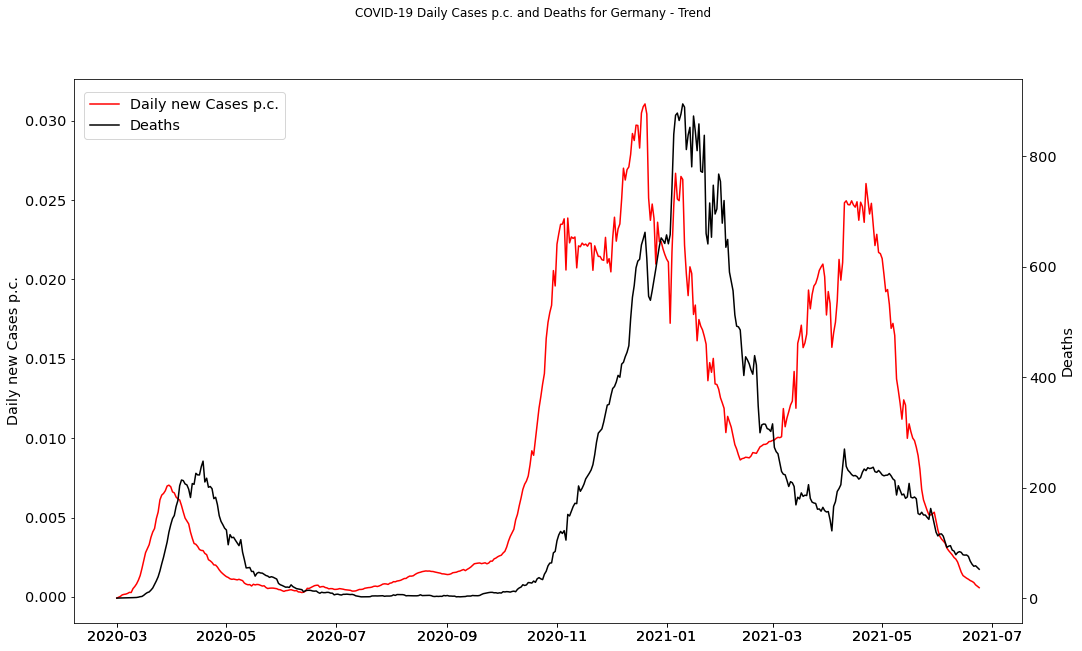

In [27]:
from pylab import figure, show, legend, ylabel

df_deaths = df1.loc[df1["Country"]=="Germany","daily_deaths"]
mid = (df_deaths.loc['2020-04-11']+df_deaths.loc['2020-04-12'])/2
df_deaths.loc['2020-04-11'], df_deaths.loc['2020-04-12'] = mid, mid
df_deaths[df_deaths<=0]=1
df_deaths_dec = seasonal_decompose(df_deaths, model='multiplicative', extrapolate_trend='freq', period=7)
D_deaths_trend = pd.Series(data=df_deaths_dec.trend.values, index = df1[df1["Country"]=="Germany"].index)

daily_new_p = df1.loc[df1["Country"]=="Germany", "daily_new_cases"]/df1.loc[df1["Country"]=="Germany", "pop_2018"]*100
dec_mul_p = seasonal_decompose(daily_new_p, model='multiplicative', extrapolate_trend='freq', period=7)
D_daily_new = pd.Series(data=dec_mul_p.trend.values, index = df1[df1["Country"]=="Germany"].index)

#D_deaths_trend.plot()
#df_deaths_dec.trend.plot()

# create the general figure
fig1 = figure()
fig1.suptitle("COVID-19 Daily Cases p.c. and Deaths for Germany - Trend")
# and the first axes using subplot populated with data 
ax1 = fig1.add_subplot(111)
line1, = ax1.plot(D_daily_new, '-', color="red", label="Daily new Cases p.c.")
ylabel("Daily new Cases p.c.")
 
# now, the second axes that shares the x-axis with the ax1
ax2 = fig1.add_subplot(111, sharex=ax1, frameon=False)
line2, = ax2.plot(D_deaths_trend, '-', color="black", label="Deaths")
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ylabel("Deaths")
 
# for the legend, remember that we used two different axes so, we need 
# to build the legend manually
legend(handles=[line1, line2],bbox_to_anchor=(0.23,0.99))

show()

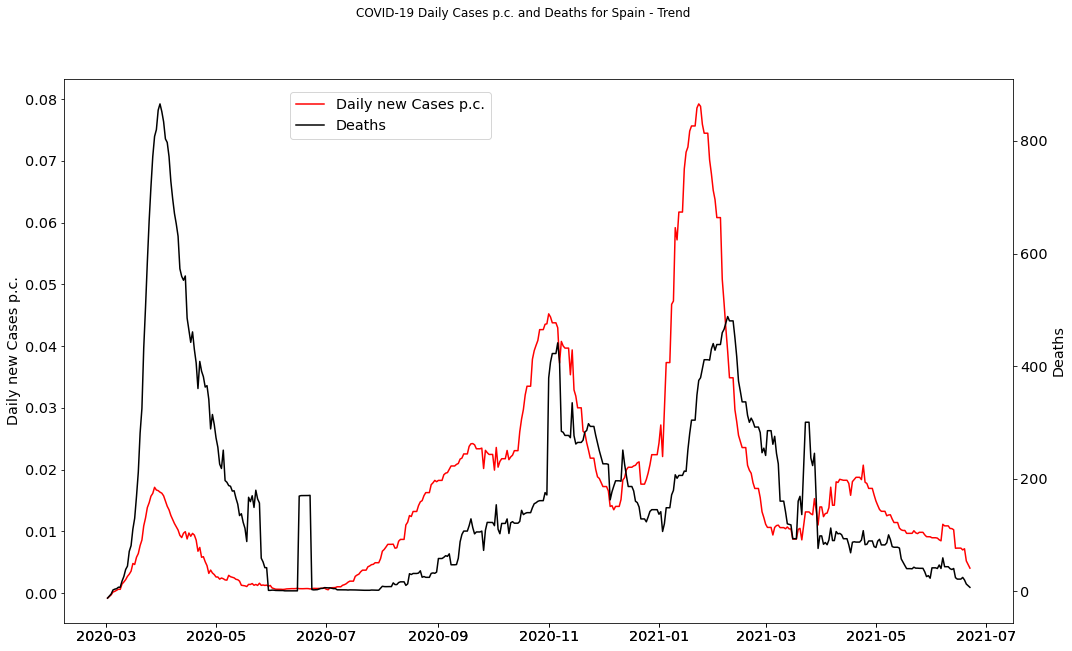

In [6]:
country = "Spain"
df_deaths = df1.loc[df1["Country"]==country,"daily_deaths"]
mid = (df_deaths.loc['2020-04-11']+df_deaths.loc['2020-04-12'])/2
df_deaths.loc['2020-04-11'], df_deaths.loc['2020-04-12'] = mid, mid
df_deaths[df_deaths<=0]=1
df_deaths_dec = seasonal_decompose(df_deaths, model='multiplicative', extrapolate_trend='freq', period=7)
D_deaths_trend = pd.Series(data=df_deaths_dec.trend.values, index = df1[df1["Country"]==country].index)

daily_new_p = df1.loc[df1["Country"]==country, "daily_new_cases"]/df1.loc[df1["Country"]==country, "pop_2018"]*100
dec_mul_p = seasonal_decompose(daily_new_p, model='multiplicative', extrapolate_trend='freq', period=7)
D_daily_new = pd.Series(data=dec_mul_p.trend.values, index = df1[df1["Country"]==country].index)

#D_deaths_trend.plot()
#df_deaths_dec.trend.plot()

# create the general figure
fig1 = figure()
fig1.suptitle("COVID-19 Daily Cases p.c. and Deaths for {} - Trend".format(country))
# and the first axes using subplot populated with data 
ax1 = fig1.add_subplot(111)
line1, = ax1.plot(D_daily_new, '-', color="red", label="Daily new Cases p.c.")
ylabel("Daily new Cases p.c.")
 
# now, the second axes that shares the x-axis with the ax1
ax2 = fig1.add_subplot(111, sharex=ax1, frameon=False)
line2, = ax2.plot(D_deaths_trend, '-', color="black", label="Deaths")
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ylabel("Deaths")
 
# for the legend, remember that we used two different axes so, we need 
# to build the legend manually
legend(handles=[line1, line2],bbox_to_anchor=(0.23,0.99))

show()